In [ ]:
# %%capture --no-stderr
# %pip install -U colorama langgraph langchain-community langchain-openai langchain-anthropic tavily-python pandas openai lancedb sentence-transformers

## **Customer Email Agent**

## Useful Helpers

In [2]:
from langchain_core.messages import ToolMessage, SystemMessage, AIMessage, HumanMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import Runnable, RunnableConfig
from typing import TypedDict, Annotated
from langgraph.graph.message import AnyMessage, add_messages
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition
import torch

# llm = ChatOpenAI(model="gpt-3.5-turbo")
memory = (
    MemorySaver()
)  # it'll save the all the states and history corresponding to a `thread_id`. We can get previous conversations if we use memory

# ------------ Vector Search ----------------
!rm -rf "./lancedb"

import lancedb, re, requests
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
import numpy as np
from langchain_core.tools import tool

# ------- Vector DB using LanceDB ------------
model = (
    get_registry()
    .get("sentence-transformers")
    .create(
        name="BAAI/bge-small-en-v1.5",
        device="cuda" if torch.cuda.is_available() else "cpu",
    )
)


class Policy(LanceModel):
    text: str = model.SourceField()
    vector: Vector(model.ndims()) = model.VectorField()


response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text


class VectorStoreRetriever:
    def __init__(
        self,
        db_path: str,
        table_name: str,
        model,
        docs: list,
        schema,
    ):
        self.db = lancedb.connect(db_path)
        self.table = self.db.create_table(table_name, schema=schema)
        self.table.add([{"text": txt} for txt in re.split(r"(?=\n##)", faq_text)])

    def query(self, query: str, k: int = 5) -> list[dict]:
        result = self.table.search(query).limit(k).to_list()
        return [
            {"page_content": item["text"], "similarity": 1 - item["_distance"]}
            for item in result
        ]


retriever = VectorStoreRetriever("./lancedb", "company_policy", model, faq_text, Policy)

'rm' is not recognized as an internal or external command,
operable program or batch file.


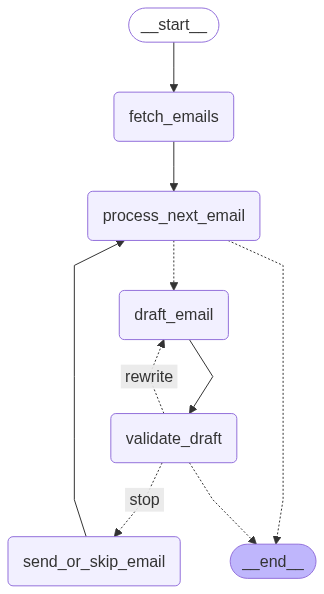

Starting workflow...
Finished running: fetch_emails
Finished running: process_next_email
Finished running: draft_email
Finished running: validate_draft
Finished running: draft_email


-----------------------Sending Email ---------------


Finished running: validate_draft


Sending email: Subject: Re: Invoice Request for Recent Flight Booking

Dear Ms. Müller,

Thank you for reaching out to us regarding your recent flight booking with SWISS Airlines. We appreciate your choice to fly with us.

To obtain your invoice for the booking with reference number LX123456, please follow these simple steps:

1. Visit our website at www.swiss.com.
2. Navigate to the "Manage Booking" section.
3. Enter your booking reference and your last name to access your reservation.
4. Once in your booking details, you will find the option to download your invoice.

Alternatively, if you prefer, I can assist you directly. Please confirm your request, and I would be happy to send the invoice to your email.

Should

In [3]:
from typing import Optional, List
from pydantic import BaseModel
from langchain_core.prompts import PromptTemplate
from langchain_openai import AzureChatOpenAI, ChatOpenAI  # Ensure ChatOpenAI is imported
from langgraph.graph import END, StateGraph, START
import os
from dotenv import load_dotenv
import random
from typing import Annotated
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict
from langchain_core.messages import ToolMessage, SystemMessage, AIMessage, HumanMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition
import lancedb, re, requests
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
import numpy as np
from langchain_core.tools import tool
from dotenv import load_dotenv
import os
from colorama import Fore, Style

load_dotenv()

# Access the previously defined API key
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Set the environment variable for ChatOpenAI to pick it up
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY


memory = (
    MemorySaver()
)  # it'll save the all the states and history corresponding to a `thread_id`. We can get previous conversations if we use memory


class Email(BaseModel):
    id: str
    sender: str
    subject: str
    body: str
    final_reply: str = ""
    status: str = "pending"  # pending, sent, failed, skipped
    failure_reason: str = ""


class EmailState(BaseModel):
    emails: List[Email] = []
    processed_emails: List[Email] = []
    current_email: Optional[Email] = None
    policy_context: Optional[str] = ""
    draft: str = ""
    trials: int = 0
    allowed_trials: int = 3
    sendable: bool = False
    exit: bool = False


def create_dummy_random_emails():
    items = [
        {
            "subject": "Invoice Request for Recent Flight Booking",
            "body": "Hey SWISS Team, I recently booked a flight with you (Booking Reference: LX123456) and need an invoice for my records. Could you let me know how to get it? Thanks! Anna Müller",
        },
        {
            "subject": "Rebooking Inquiry for Upcoming Flight",
            "body": "Hi there, I need to change the dates for my flight (Booking Reference: LX789012). Can you let me know if this is possible and what fees I might have to pay? Cheers, John Smith",
        },
        {
            "subject": "Cancellation of Flight LX345678",
            "body": "Hi SWISS, I need to cancel my flight (Booking Reference: LX345678) because of some unexpected changes. Can you walk me through the cancellation process and any fees? Thanks, Maria Gonzalez",
        },
        {
            "subject": "Request for Special Invoice for Italy",
            "body": "Hi SWISS, I booked a flight from Italy and need a special invoice for tax reasons. Can you help me out with this? Thanks, Luca Rossi",
        },
        {
            "subject": "Payment Issue with Credit Card",
            "body": "Hey, I tried paying for my booking with my Visa card, but it didn’t go through. Can you check if it’s an issue with my card or your system? Thanks, Emily Brown",
        },
        {
            "subject": "Refund Status for Cancelled Flight",
            "body": "Hi SWISS, I cancelled my flight (Booking Reference: LX456789) a couple of weeks ago and was told I’d get a refund. Any updates on that? Thanks, David Johnson",
        },
        {
            "subject": "Seat Reservation Inquiry",
            "body": "Hey, I have a booking (Reference: LX567890) and wanted to check if my seat reservation will stay the same after a rebooking. Let me know! Sophie Lee",
        },
        {
            "subject": "Upgrade Request for Economy Flex Fare",
            "body": "Hi SWISS, I booked an Economy Flex fare and was wondering if I can upgrade to Business Class. Can you let me know how to do that? Thanks, Michael Chen",
        },
        {
            "subject": "Group Booking Inquiry",
            "body": "Hi, I’m looking to book flights for a group of 12 people. Can you give me some info on group booking options and any discounts? Thanks, Sarah Wilson",
        },
        {
            "subject": "Issue with Online Booking Platform",
            "body": "Hey SWISS, I can’t see my recent booking in my profile on your website. Can you help me fix this? Thanks, Thomas Anderson",
        },
    ]
    chosen_items = [random.choice(items) for _ in range(random.randint(0, 2))]
    return [
        Email(
            id=str(i),
            sender="divakarkumar8803@gmail.com",
            subject=item["subject"],
            body=item["body"],
        )
        for i, item in enumerate(chosen_items)
    ]


class EmailAgent:
    def __init__(self):
        # ChatOpenAI will now pick up the API key from the environment variable
        self.llm = ChatOpenAI(model="gpt-4o-mini")

    def fetch_unread_emails(self) -> List[Email]:
        """
        Replace this with your Email LOGIC
        """
        return create_dummy_random_emails()

    def lookup_policy(self, subject: str, body: str) -> str:
        """Always Consult the company policies to answer the queries.
        Use this for drafting the emails"""
        prompt = PromptTemplate(
            template="Identify whether the given email is policy related or not. Identify if the email requires info which might be in the policy documents.\n\nSubject: {subject}\n\nBody:\n{body}\n\n. Do not output any reasoning etc. Strictly reply with Yes/No",
            input_variables=["subject", "body"], # Corrected input_variables
        )
        chain = prompt | self.llm
        response = chain.invoke({"subject": subject, "body": body})
        policy_related = response.content.strip().lower() == "yes"
        if policy_related:
            # Ensure retriever is accessible if it's not a global variable
            # Assuming retriever is a global variable based on the context provided
            docs = retriever.query(
                f"Email Subject: {subject}\n\nEmail Body:\n{body}", k=2
            )
            return "\nPolicy Context:" + "\n\n".join(
                [doc["page_content"] for doc in docs]
            )
        return ""

    def draft_email(
        self, email_subject: str, email_body: str, email_context: str = ""
    ) -> str:
        if not email_context:
            prompt = PromptTemplate(
                template="You are a specialised chat agent named Saleem Shady' working for SWISS Airline. Write a well professional response to this user email:\n\nEmail Subject: {email_subject}\n\nEmail Body:\n{email_body}\n\nReply with a perfect response, nothing else\nResponse:",
                input_variables=["email_subject", "email_body"], # Corrected input_variables
            )
        else:
            prompt = PromptTemplate(
                template="You are a specialised chat agent named Saleem Shady' working for SWISS Airline. Write a well professional response to this user email given the Context (which may or may not be required in answering)\n\n{email_context}\n\nEmail Subject: {email_subject}\n\nEmail Body:\n{email_body}\n\nReply with a perfect response, nothing else\nResponse:",
                input_variables=["email_subject", "email_body", "email_context"], # Corrected input_variables
            )

        chain = prompt | self.llm
        response = chain.invoke(
            {
                "email_subject": email_subject,
                "email_body": email_body,
                "email_context": email_context,
            }
        )
        return response.content

    def validate_draft(self, initial_email: str, draft_email: str) -> bool:
        prompt = PromptTemplate(
            template="You are a Email Proofreader. Review this response:\n\nOriginal Email:\n{initial_email}\n\nDraft Response:\n{draft_email}\n\nIs this mail ready to send? Do not give your reasoning or views. Reply only with (Yes/No):",
            input_variables=["initial_email", "draft_email"],
        )
        chain = prompt | self.llm
        response = chain.invoke(
            {"initial_email": initial_email, "draft_email": draft_email}
        )
        return response.content.strip().lower() == "yes"


def create_workflow():
    workflow = StateGraph(EmailState)
    agent = EmailAgent()

    def fetch_emails(state: EmailState) -> EmailState:
        emails = agent.fetch_unread_emails()
        state.emails = emails
        return state

    def process_next_email(state: EmailState) -> EmailState:
        if state.emails:
            state.current_email = state.emails.pop(0)
            # Pass subject and body as separate arguments
            state.policy_context = agent.lookup_policy(
                state.current_email.subject, state.current_email.body
            )
        else:
            state.exit = True
        return state

    def draft_email(state: EmailState) -> EmailState:
        if state.current_email:
            # Pass subject, body, and context as separate arguments
            state.draft = agent.draft_email(
                state.current_email.subject,
                state.current_email.body,
                state.policy_context,
            )
            state.trials += 1
        return state

    def validate_draft(state: EmailState) -> EmailState:
        if state.current_email and state.draft:
            state.sendable = agent.validate_draft(state.current_email.body, state.draft)
        return state

    def decide_next_step(state: EmailState) -> str:
        if state.sendable:
            print("\n\n-----------------------Sending Email ---------------\n\n")
            return "send"
        elif state.trials >= state.allowed_trials:
            state.current_email.status = "failed"
            state.current_email.failure_reason = "Failed after 3 attempts"
            print(
                "\n\n*********************** Draft Failed after Max Tries ******************** \n\n"
            )
            return "stop"
        else:
            return "rewrite"

    def send_or_skip_email(state: EmailState) -> EmailState:
        if state.current_email.status != "failed":
            print(f"\n\nSending email: {state.draft}")
            state.current_email.final_reply = state.draft
            state.current_email.status = "sent"
            state.processed_emails.append(state.current_email)

        # Reset state for the next email
        state.current_email = None
        state.draft = ""
        state.trials = 0
        state.policy_context = ""
        return state

    workflow.add_node("fetch_emails", fetch_emails)
    workflow.add_node("process_next_email", process_next_email)
    workflow.add_node("draft_email", draft_email)
    workflow.add_node("validate_draft", validate_draft)
    workflow.add_node("send_or_skip_email", send_or_skip_email)

    workflow.add_edge(START, "fetch_emails")
    workflow.add_edge("fetch_emails", "process_next_email")

    workflow.add_conditional_edges(
        "process_next_email",
        lambda state: END if state.exit else "draft_email",
        {"draft_email": "draft_email", END: END},
    )

    workflow.add_edge("draft_email", "validate_draft")

    workflow.add_conditional_edges(
        "validate_draft",
        decide_next_step,
        {
            "send": "send_or_skip_email",
            "rewrite": "draft_email",
            "stop": "send_or_skip_email",
        },
    )

    workflow.add_edge("send_or_skip_email", "process_next_email")

    return workflow.compile()


compiled_email_subgraph = create_workflow()
initial_state = EmailState()

from IPython.display import Image, display

try:
    display(Image(compiled_email_subgraph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass


print(Fore.GREEN + "Starting workflow..." + Style.RESET_ALL)
for output in compiled_email_subgraph.stream(initial_state):
    for key, value in output.items():
        print(Fore.CYAN + f"Finished running: {key}" + Style.RESET_ALL)
        # print(Fore.YELLOW + f"State after {key}:" + Style.RESET_ALL)
        # print(value)